In [ ]:
import cv2
import mediapipe as mp
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy import signal

# Preprocessing: scaler
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt;
from sklearn.model_selection import cross_val_score

import pickle
import pingouin as pg

mpHands = mp.solutions.hands
hands = mpHands.Hands()
mpDraw = mp.solutions.drawing_utils

In [ ]:
# mediapipe hand detection from video
name = '292.mp4'
cap = cv2.VideoCapture(name)
allList = []

while(cap.isOpened()):
    success, img = cap.read()
    if success:
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = hands.process(imgRGB)
        if results.multi_hand_landmarks:
            lmList = []
            for handLms in results.multi_hand_landmarks:
                for id, lm in enumerate(handLms.landmark):
                    h, w, c = img.shape
                    cx, cy = int(lm.x*w), int(lm.y*h)
                    ts = cap.get(cv2.CAP_PROP_POS_MSEC)
                    if id == 4 or id == 8:                    
                        lmList.append([id, cx, cy, ts])
                        print("id:", id,"x:",cx, "y:", cy, "time:", ts)
                mpDraw.draw_landmarks(img, handLms, mpHands.HAND_CONNECTIONS)
        cv2.imshow("image", img)
    else:
        break
    allList.append(lmList)
    cv2.waitKey(1)
cv2.destroyAllWindows()

# Part 1 : MediaPipe Hand detection and feature extraction

In [ ]:
# create dataframe fo
np_allList = np.array(allList)
length = []
for i in range(np_allList.shape[0]):
    x1 = np_allList[i][0][1]
    y1 = np_allList[i][0][2]
    x2 = np_allList[i][1][1]
    y2 = np_allList[i][1][2]
    x3 = np_allList[i][2][1]
    y3 = np_allList[i][2][2]
    x4 = np_allList[i][3][1]
    y4 = np_allList[i][3][2]
    ts = np_allList[i][0][3]
    
    if (x3-x1) > 0 :
        right = math.hypot(x2 - x1, y2 - y1)
        left = math.hypot(x4 - x3, y4 - y3)
    else:
        left = math.hypot(x2 - x1, y2 - y1)
        right = math.hypot(x4 - x3, y4 - y3)
    
    length.append([ts, right, left]) 
    
df = pd.DataFrame(length, columns = ['time', 'right', 'left'])
df['diff'] = (df['time'].diff())
df = df.loc[df['diff'] > 0]
del(df['diff'])
df['r'] = (df['right']/(max(df['right']))) *100
df['l'] = (df['left']/(max(df['left']))) *100
del(df['right'], df['left'])
df = df.loc[df['time'] <= 10000]
# print(df)

In [ ]:
# Find Peak and create df with peak
r_1d = df['r']
r_peak, _ = find_peaks(r_1d, prominence =30)
r_trough, _ = find_peaks(-r_1d, prominence =30)
df.loc[df.iloc[r_peak].index, 'r_peak'] = True
df.loc[df.iloc[r_trough].index, 'r_trough'] = True

l_1d = df['l']
l_peak, _ = find_peaks(l_1d, prominence =30)
l_trough, _ = find_peaks(-l_1d, prominence =30)
df.loc[df.iloc[l_peak].index, 'l_peak'] = True
df.loc[df.iloc[l_trough].index, 'l_trough'] = True

## plot and save figure
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, hspace=0.4)
axs = gs.subplots(sharex=False, sharey=False)
fig.suptitle('Finger Tapping Test', color='green', fontweight="bold", size=28)
axs[0].set_title('Right hand',color='r',fontweight="regular", size=24)
axs[0].figsize=(20,10)
axs[0].plot(df['time'], df['r'], markevery=r_peak, marker='o',color='r')
axs[0].plot(df['time'], df['r'], markevery=r_trough, marker='o',color='r')
axs[0].set_ylabel('Amplitude (%)',fontsize = 20.0)
axs[0].set_xlabel('Time (msec)',fontsize = 20.0)

axs[1].set_title('Left hand',color='b',fontweight="regular", size=24)
axs[1].plot(df['time'], df['l'], markevery=l_peak, marker='x',color='b')
axs[1].plot(df['time'], df['l'], markevery=l_trough, marker='x',color='b')
axs[1].set_ylabel('Amplitude (%)',fontsize = 20.0)
axs[1].set_xlabel('Time (msec)',fontsize = 20.0)

# save file
name_new = name.replace('.mp4','')
df.to_csv('%s.csv' % name_new)

In [ ]:
df4 = pd.read_csv('192.csv', header = 0)
rp = df4.loc[df4['r_peak']==True,['r']]
rp = rp.reset_index(drop=True)
lp = df4.loc[df4['l_peak']==True,['l']]
lp = lp.reset_index(drop=True)
df5 = pd.concat([rp,lp],axis=1)
#check NaN if less than 10 times
rtap, ltap = len(rp),len(lp)
tapmin = min(rtap,ltap)
if tapmin < 10:
    ten = pd.DataFrame({'ten': [0] * 10})
    df5 = pd.concat([df5,ten],axis=1)
    df5.fillna(0, inplace=True)
    del(df5['ten'])
    
print(df5)
print(tapmin)

In [ ]:
##### peak analysis
# variables
rp_count,lp_count = len(rp), len(lp)
tap_num = max(rp_count,lp_count)

rp_mean,rp_std = df5['r'].mean(), df5['r'].std()
rp_diff3  = df5.iloc[0,0]-df5.iloc[2,0]
rp_diff5  = df5.iloc[0,0]-df5.iloc[4,0]
rp_diff7  = df5.iloc[0,0]-df5.iloc[6,0]
rp_diff10 = df5.iloc[0,0]-df5.iloc[9,0]

lp_mean,lp_std = df5['l'].mean(), df5['l'].std()
lp_diff3  = df5.iloc[0,1]-df5.iloc[2,1]
lp_diff5  = df5.iloc[0,1]-df5.iloc[4,1]
lp_diff7  = df5.iloc[0,1]-df5.iloc[6,1]
lp_diff10 = df5.iloc[0,1]-df5.iloc[9,1]

tap_diff = abs(rp_count-lp_count)

## report 
print("Tap score (total taps in 10 seconds) :")
print("    Right         : ", rp_count)
print("    Left          : ", lp_count)
print("    Tap different): ", tap_diff)
print("Amplitude")
print("    Right, mean (sd,var):",str(round(rp_mean,2)),"(",str(round(rp_std,2)),")")
print("    Left,  mean (sd,var):",str(round(lp_mean,2)),"(",str(round(lp_std,2)),")")
print("Bradykinesia score")
print("    Right amplitude diff 1-3  :",str(round(rp_diff3,2)))
print("    Right amplitude diff 1-5  :",str(round(rp_diff5,2)))
print("    Right amplitude diff 1-7  :",str(round(rp_diff7,2)))
print("    Right amplitude diff 1-10 :",str(round(rp_diff10,2)))
print("    Left  amplitude diff 1-3  :",str(round(lp_diff3,2)))
print("    Left  amplitude diff 1-5  :",str(round(lp_diff5,2)))
print("    Left  amplitude diff 1-7  :",str(round(lp_diff7,2)))
print("    Left  amplitude diff 1-10 :",str(round(lp_diff10,2)))

# Part 2 : Load data from train ML model

In [2]:
df = pd.read_excel("df_combind.xlsx")
print(df)

   gender        handed age  PD_duration  H&Y symptom_side on_off Levodopa  \
0       f  right_handed  65          NaN  2.5        right    off      yes   
1       f  right_handed  66          4.0  1.0        right     on      yes   
2       m  right_handed  70          NaN  4.0        right     on      yes   
3       f  right_handed  47          5.0  3.0        right     on      yes   
4       f  right_handed  50          NaN  NaN          NaN    NaN      NaN   
..    ...           ...  ..          ...  ...          ...    ...      ...   
95      f  right_handed  71          NaN  NaN          NaN    NaN      NaN   
96      f  right_handed  67          NaN  NaN          NaN    NaN      NaN   
97      f  right_handed  68          NaN  NaN          NaN    NaN      NaN   
98      f  right_handed  50          1.0  1.0        right     on      yes   
99      f   left_handed  50          1.0  1.0         left    off      yes   

    updrs_rt  updrs_lt  ...   rp_diff5   rp_diff7  rp_diff10  l

# Part 3 : prepare data for ML

In [3]:
del(df['gender'],df['handed'],df['age'],df['PD_duration'],df['H&Y'],df['symptom_side'],df['on_off'],df['Levodopa'],
    df['updrs_rt'],df['updrs_lt'],df['updrs_total'],df['pd'],
    df['bradykinesia'],df['ftt01_rt'],df['ftt01_lt'],df['ftt01'])

In [4]:
print(df)

    bradykinesia1  rp_count    rp_mean     rp_std   rp_diff5   rp_diff7  \
0               1         4  25.854924  40.936364  66.931154  66.931154   
1               1        15  79.654471  12.136359  11.637161  22.564771   
2               1        13  70.745735  18.123539   7.250319  38.046197   
3               1        16  76.546025   7.986921  27.114291   5.626236   
4               0        29  80.364007   8.596210  -6.063142  10.336391   
..            ...       ...        ...        ...        ...        ...   
95              0        34  71.335809  12.830499  -1.380972   4.866167   
96              0        17  92.543872   4.646739   5.269390  -2.547657   
97              0        24  84.182118   6.934865  10.509525  16.269154   
98              1        17  90.482241   4.787156   8.971359   9.313937   
99              1        16  74.619199   8.969255   9.881528   9.054608   

    rp_diff10  lp_count    lp_mean     lp_std   lp_diff5   lp_diff7  \
0   66.931154        13  67.

In [5]:
X = df.drop('bradykinesia1', axis=1)
y = df['bradykinesia1']

# Part 4 : train ML with cross-validation

In [6]:
## Logistic regression
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],  # Type of regularization
    'solver': ['liblinear', 'saga']  # Solver that supports different penalties
}

# Initialize Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# To store results
outer_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'test_auc': [],
    'train_auc': []
}

# Perform Nested Cross-Validation
for train_index, test_index in outer_cv.split(X, y):
    # Outer loop: Split into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=logreg_model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model from inner cross-validation
    best_model = grid_search.best_estimator_
    
    # Predict on training and testing sets
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)
    
    # Calculate training and test AUC
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # Calculate metrics on the test set
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, zero_division=1)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    # Store metrics
    outer_metrics['accuracy'].append(accuracy)
    outer_metrics['precision'].append(precision)
    outer_metrics['recall'].append(recall)
    outer_metrics['f1'].append(f1)
    outer_metrics['test_auc'].append(test_auc)
    outer_metrics['train_auc'].append(train_auc)
    
    print(f"Fold Results:")
    print(f"  Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, Test AUC: {test_auc:.2f}, Training AUC: {train_auc:.2f}")
    print(f"  Best Parameters: {grid_search.best_params_}")
    
from scipy.stats import t
# Calculate mean, standard deviation, and 95% confidence intervals
n_folds = len(outer_metrics['accuracy'])  # Number of outer folds
confidence_level = 0.95  # Confidence level
df = n_folds - 1  # Degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df)  # t-value for 95% CI

# Print results with confidence intervals
print("\nFinal Results with 95% Confidence Intervals:")
for metric, values in outer_metrics.items():
    mean_metric = np.mean(values)
    std_metric = np.std(values)
    margin_error = t_value * (std_metric / np.sqrt(n_folds))
    ci_lower = mean_metric - margin_error
    ci_upper = mean_metric + margin_error

    print(f"{metric.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {mean_metric:.2f}")
    print(f"  Standard Deviation: {std_metric:.2f}")
    print(f"  95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

Fold Results:
  Accuracy: 0.75, Precision: 0.71, Recall: 0.91, F1-Score: 0.80, Test AUC: 0.83, Training AUC: 0.97
  Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Fold Results:
  Accuracy: 0.80, Precision: 1.00, Recall: 0.64, F1-Score: 0.78, Test AUC: 0.91, Training AUC: 0.96
  Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Fold Results:
  Accuracy: 0.80, Precision: 0.82, Recall: 0.82, F1-Score: 0.82, Test AUC: 0.84, Training AUC: 0.96
  Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Fold Results:
  Accuracy: 0.95, Precision: 1.00, Recall: 0.90, F1-Score: 0.95, Test AUC: 1.00, Training AUC: 0.94
  Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Fold Results:
  Accuracy: 0.65, Precision: 0.64, Recall: 0.70, F1-Score: 0.67, Test AUC: 0.79, Training AUC: 0.96
  Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Final Results with 95% Confidence Intervals:
Accuracy:
  Mean: 0.79
  Standard Dev

In [ ]:
# svc 
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

svm_model = SVC(random_state=42, probability=True)

outer_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'test_auc': [],
    'train_auc': []
}

# Variable to track the best model and its performance
best_model_overall = None
best_test_auc = -np.inf  # Initialize with a very low value

# Perform Nested Cross-Validation
for train_index, test_index in outer_cv.split(X, y):
    # Outer loop: Split into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=svm_model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model from inner cross-validation
    best_model = grid_search.best_estimator_
    
    # Predict on training and testing sets
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)
    
    # Calculate training and test AUC
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # Check if this is the best model overall
    if test_auc > best_test_auc:
        best_test_auc = test_auc
        best_model_overall = best_model  # Save the best model
    
    # Calculate metrics on the test set
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, zero_division=1)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    # Store metrics
    outer_metrics['accuracy'].append(accuracy)
    outer_metrics['precision'].append(precision)
    outer_metrics['recall'].append(recall)
    outer_metrics['f1'].append(f1)
    outer_metrics['test_auc'].append(test_auc)
    outer_metrics['train_auc'].append(train_auc)
    
    print(f"Fold Results:")
    print(f"  Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, Test AUC: {test_auc:.2f}, Training AUC: {train_auc:.2f}")
    print(f"  Best Parameters: {grid_search.best_params_}")

# Save the best model overall
model_filename = "svm_best_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model_overall, file)
    
# Calculate mean, standard deviation, and 95% confidence intervals
n_folds = len(outer_metrics['accuracy'])  # Number of outer folds
confidence_level = 0.95  # Confidence level
df = n_folds - 1  # Degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df)  # t-value for 95% CI

# Print results with confidence intervals
print("\nFinal Results with 95% Confidence Intervals:")
for metric, values in outer_metrics.items():
    mean_metric = np.mean(values)
    std_metric = np.std(values)
    margin_error = t_value * (std_metric / np.sqrt(n_folds))
    ci_lower = mean_metric - margin_error
    ci_upper = mean_metric + margin_error

    print(f"{metric.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {mean_metric:.2f}")
    print(f"  Standard Deviation: {std_metric:.2f}")
    print(f"  95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

In [ ]:
## random forest ##
# Define outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, None]
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# To store results
outer_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'test_auc': [],
    'train_auc': []
}

# Perform Nested Cross-Validation
for train_index, test_index in outer_cv.split(X, y):
    # Outer loop: Split into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=rf_model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model from inner cross-validation
    best_model = grid_search.best_estimator_
    
    # Predict on training and testing sets
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)
    
    # Calculate training and test AUC
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # Calculate metrics on the test set
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, zero_division=1)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    # Store metrics
    outer_metrics['accuracy'].append(accuracy)
    outer_metrics['precision'].append(precision)
    outer_metrics['recall'].append(recall)
    outer_metrics['f1'].append(f1)
    outer_metrics['test_auc'].append(test_auc)
    outer_metrics['train_auc'].append(train_auc)
    
    print(f"Fold Results:")
    print(f"  Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, Test AUC: {test_auc:.2f}, Training AUC: {train_auc:.2f}")
    print(f"  Best Parameters: {grid_search.best_params_}")
    
from scipy.stats import t
# Calculate mean, standard deviation, and 95% confidence intervals
n_folds = len(outer_metrics['accuracy'])  # Number of outer folds
confidence_level = 0.95  # Confidence level
df = n_folds - 1  # Degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df)  # t-value for 95% CI

# Print results with confidence intervals
print("\nFinal Results with 95% Confidence Intervals:")
for metric, values in outer_metrics.items():
    mean_metric = np.mean(values)
    std_metric = np.std(values)
    margin_error = t_value * (std_metric / np.sqrt(n_folds))
    ci_lower = mean_metric - margin_error
    ci_upper = mean_metric + margin_error

    print(f"{metric.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {mean_metric:.2f}")
    print(f"  Standard Deviation: {std_metric:.2f}")
    print(f"  95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")
    
from scipy.stats import t
# Calculate mean, standard deviation, and 95% confidence intervals
n_folds = len(outer_metrics['accuracy'])  # Number of outer folds
confidence_level = 0.95  # Confidence level
df = n_folds - 1  # Degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df)  # t-value for 95% CI

# Print results with confidence intervals
print("\nFinal Results with 95% Confidence Intervals:")
for metric, values in outer_metrics.items():
    mean_metric = np.mean(values)
    std_metric = np.std(values)
    margin_error = t_value * (std_metric / np.sqrt(n_folds))
    ci_lower = mean_metric - margin_error
    ci_upper = mean_metric + margin_error

    print(f"{metric.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {mean_metric:.2f}")
    print(f"  Standard Deviation: {std_metric:.2f}")
    print(f"  95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

In [ ]:
## decision tree ##
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criterion for splitting
    'max_depth': [3, 5, 10, None]      # Maximum depth of the tree
}

# Initialize Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# To store results
outer_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'test_auc': [],
    'train_auc': []
}

# Perform Nested Cross-Validation
for train_index, test_index in outer_cv.split(X, y):
    # Outer loop: Split into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=dt_model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model from inner cross-validation
    best_model = grid_search.best_estimator_
    
    # Predict on training and testing sets
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)
    
    # Calculate training and test AUC
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # Calculate metrics on the test set
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, zero_division=1)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    # Store metrics
    outer_metrics['accuracy'].append(accuracy)
    outer_metrics['precision'].append(precision)
    outer_metrics['recall'].append(recall)
    outer_metrics['f1'].append(f1)
    outer_metrics['test_auc'].append(test_auc)
    outer_metrics['train_auc'].append(train_auc)
    
    print(f"Fold Results:")
    print(f"  Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, Test AUC: {test_auc:.2f}, Training AUC: {train_auc:.2f}")
    print(f"  Best Parameters: {grid_search.best_params_}")
    
from scipy.stats import t
# Calculate mean, standard deviation, and 95% confidence intervals
n_folds = len(outer_metrics['accuracy'])  # Number of outer folds
confidence_level = 0.95  # Confidence level
df = n_folds - 1  # Degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df)  # t-value for 95% CI

# Print results with confidence intervals
print("\nFinal Results with 95% Confidence Intervals:")
for metric, values in outer_metrics.items():
    mean_metric = np.mean(values)
    std_metric = np.std(values)
    margin_error = t_value * (std_metric / np.sqrt(n_folds))
    ci_lower = mean_metric - margin_error
    ci_upper = mean_metric + margin_error

    print(f"{metric.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {mean_metric:.2f}")
    print(f"  Standard Deviation: {std_metric:.2f}")
    print(f"  95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

In [ ]:
## LGBM
# Define outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid for LightGBM
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.3]  # Learning rate
}

# Initialize LightGBM Classifier
lgbm_model = LGBMClassifier(random_state=42)

# To store results
outer_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'test_auc': [],
    'train_auc': []
}

# Perform Nested Cross-Validation
for train_index, test_index in outer_cv.split(X, y):
    # Outer loop: Split into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=lgbm_model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model from inner cross-validation
    best_model = grid_search.best_estimator_
    
    # Predict on training and testing sets
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)
    
    # Calculate training and test AUC
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # Calculate metrics on the test set
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, zero_division=1)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    # Store metrics
    outer_metrics['accuracy'].append(accuracy)
    outer_metrics['precision'].append(precision)
    outer_metrics['recall'].append(recall)
    outer_metrics['f1'].append(f1)
    outer_metrics['test_auc'].append(test_auc)
    outer_metrics['train_auc'].append(train_auc)
    
    print(f"Fold Results:")
    print(f"  Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, Test AUC: {test_auc:.2f}, Training AUC: {train_auc:.2f}")
    print(f"  Best Parameters: {grid_search.best_params_}")

from scipy.stats import t
# Calculate mean, standard deviation, and 95% confidence intervals
n_folds = len(outer_metrics['accuracy'])  # Number of outer folds
confidence_level = 0.95  # Confidence level
df = n_folds - 1  # Degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df)  # t-value for 95% CI

# Print results with confidence intervals
print("\nFinal Results with 95% Confidence Intervals:")
for metric, values in outer_metrics.items():
    mean_metric = np.mean(values)
    std_metric = np.std(values)
    margin_error = t_value * (std_metric / np.sqrt(n_folds))
    ci_lower = mean_metric - margin_error
    ci_upper = mean_metric + margin_error

    print(f"{metric.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {mean_metric:.2f}")
    print(f"  Standard Deviation: {std_metric:.2f}")
    print(f"  95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

In [ ]:
## KNN ###
# Define outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance']
}

# Initialize KNN Classifier
knn_model = KNeighborsClassifier()

# To store results
outer_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'test_auc': [],
    'train_auc': []
}

# Perform Nested Cross-Validation
for train_index, test_index in outer_cv.split(X, y):
    # Outer loop: Split into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=knn_model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model from inner cross-validation
    best_model = grid_search.best_estimator_
    
    # Predict on training and testing sets
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = best_model.predict(X_test)
    
    # Calculate training and test AUC
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # Calculate metrics on the test set
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, zero_division=1)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    # Store metrics
    outer_metrics['accuracy'].append(accuracy)
    outer_metrics['precision'].append(precision)
    outer_metrics['recall'].append(recall)
    outer_metrics['f1'].append(f1)
    outer_metrics['test_auc'].append(test_auc)
    outer_metrics['train_auc'].append(train_auc)
    
    print(f"Fold Results:")
    print(f"  Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, Test AUC: {test_auc:.2f}, Training AUC: {train_auc:.2f}")
    print(f"  Best Parameters: {grid_search.best_params_}")

from scipy.stats import t
# Calculate mean, standard deviation, and 95% confidence intervals
n_folds = len(outer_metrics['accuracy'])  # Number of outer folds
confidence_level = 0.95  # Confidence level
df = n_folds - 1  # Degrees of freedom
t_value = t.ppf((1 + confidence_level) / 2, df)  # t-value for 95% CI

# Print results with confidence intervals
print("\nFinal Results with 95% Confidence Intervals:")
for metric, values in outer_metrics.items():
    mean_metric = np.mean(values)
    std_metric = np.std(values)
    margin_error = t_value * (std_metric / np.sqrt(n_folds))
    ci_lower = mean_metric - margin_error
    ci_upper = mean_metric + margin_error

    print(f"{metric.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {mean_metric:.2f}")
    print(f"  Standard Deviation: {std_metric:.2f}")
    print(f"  95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

# Part 5 : Plot Multiple ROC curve

Processing Logistic Regression...
  Fold AUC: 0.89
  Fold AUC: 0.87
  Fold AUC: 0.84
  Fold AUC: 1.00
  Fold AUC: 0.79
Completed Logistic Regression.
Processing SVM...
  Fold AUC: 0.88
  Fold AUC: 0.96
  Fold AUC: 0.86
  Fold AUC: 0.98
  Fold AUC: 0.86
Completed SVM.
Processing Random Forest...
  Fold AUC: 0.79
  Fold AUC: 0.99
  Fold AUC: 0.89
  Fold AUC: 0.89
  Fold AUC: 0.80
Completed Random Forest.
Processing Decision Tree...
  Fold AUC: 0.60
  Fold AUC: 0.75
  Fold AUC: 0.86
  Fold AUC: 0.80
  Fold AUC: 0.67
Completed Decision Tree.
Processing LightGBM...
  Fold AUC: 0.79
  Fold AUC: 0.92
  Fold AUC: 0.78
  Fold AUC: 0.92
  Fold AUC: 0.72
Completed LightGBM.
Processing KNN...
  Fold AUC: 0.72
  Fold AUC: 0.82
  Fold AUC: 0.72
  Fold AUC: 0.87
  Fold AUC: 0.86
Completed KNN.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


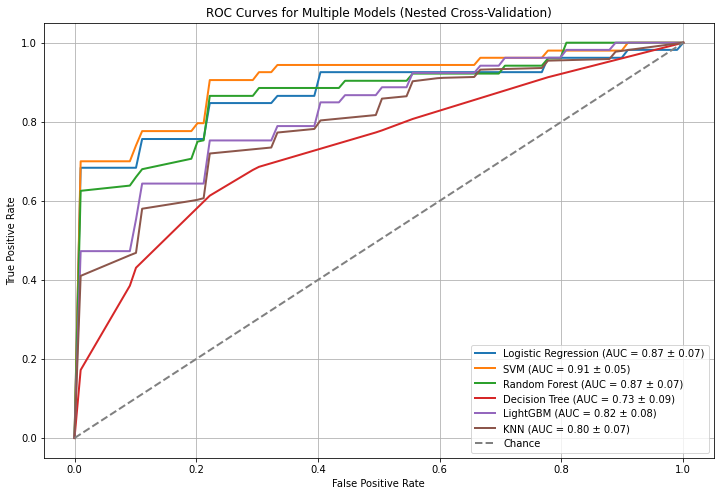

In [7]:
# multiple roc plot
# Define models and hyperparameter grids
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42), 
                            {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear', 'saga']}),
    
    "SVM": (SVC(probability=True, random_state=42),
            {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),

    "Random Forest": (RandomForestClassifier(random_state=42),
                      {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),

    "Decision Tree": (DecisionTreeClassifier(random_state=42),
                      {'max_depth': [5, 10, None], 'criterion': ['gini', 'entropy']}),

    "LightGBM": (LGBMClassifier(random_state=42),
                 {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),

    "KNN": (KNeighborsClassifier(),
            {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']})
}

# Define outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each model
roc_data = {name: {'tprs': [], 'aucs': [], 'mean_fpr': np.linspace(0, 1, 100)} for name in models}

# Perform nested cross-validation for each model
for name, (model, param_grid) in models.items():
    print(f"Processing {name}...")
    for train_index, test_index in outer_cv.split(X, y):
        # Split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Inner CV for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            estimator=model, param_grid=param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        # Get the best model and predict probabilities
        best_model = grid_search.best_estimator_
        y_test_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        roc_data[name]['aucs'].append(roc_auc)
        
        # Interpolate TPR values to the mean FPR points
        tpr_interp = np.interp(roc_data[name]['mean_fpr'], fpr, tpr)
        tpr_interp[0] = 0.0
        roc_data[name]['tprs'].append(tpr_interp)
        print(f"  Fold AUC: {roc_auc:.2f}")
        
    print(f"Completed {name}.")

# Plot the ROC curves for all models
plt.figure(figsize=(12, 8))
for name, data in roc_data.items():
    mean_tpr = np.mean(data['tprs'], axis=0)
    mean_tpr[-1] = 1.0  # Ensure the last point is 1
    mean_auc = auc(data['mean_fpr'], mean_tpr)
    std_auc = np.std(data['aucs'])
    plt.plot(data['mean_fpr'], mean_tpr, lw=2, label=f"{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})")

# Add chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance", lw=2)

# Add labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multiple Models (Nested Cross-Validation)")
plt.legend(loc="lower right")
plt.grid()


plt.savefig('fig2_cv_multiROC.jpg', dpi=300)
plt.savefig('fig2_cv_multiROC.eps', format='eps')
plt.show()

# Part 6 : plot SHAP plot

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


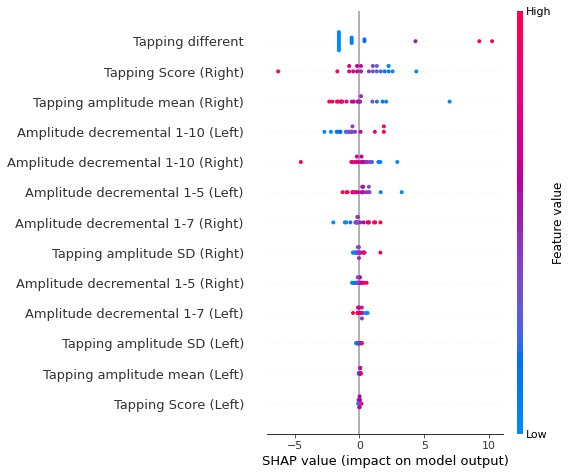

In [8]:
# shap figure
import shap
model_filename = "svm_best_model.pkl"
with open(model_filename, 'rb') as file:
    best_model = pickle.load(file)

# Feature names
feature_names = [
    'Tapping Score (Right)',
    'Tapping amplitude mean (Right)',
    'Tapping amplitude SD (Right)',
    'Amplitude decremental 1-5 (Right)',
    'Amplitude decremental 1-7 (Right)',
    'Amplitude decremental 1-10 (Right)',
    'Tapping Score (Left)',
    'Tapping amplitude mean (Left)',
    'Tapping amplitude SD (Left)',
    'Amplitude decremental 1-5 (Left)',
    'Amplitude decremental 1-7 (Left)',
    'Amplitude decremental 1-10 (Left)',
    'Tapping different'
]

# Ensure X_train and X_test are prepared (replace these with your actual data)
# Example: X_train, X_test are pandas DataFrames with appropriate features
# Make sure the feature order in X_train and X_test matches `feature_names`.

# Create the SHAP explainer for the loaded Logistic Regression model
explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)

# Save the plots in different formats
plt.savefig('Figure 3 new_plos SHAP.eps', format='eps')
plt.savefig('Figure 3 new_plos SHAP.jpg', dpi=300)
plt.savefig('Figure 3 new_plos SHAP.png', dpi=300)
plt.show()

# Part 7 : load model to detect bradykinesia

In [ ]:
# read csv data
name = '292.csv'
df = pd.read_csv(name, index_col=None, header=0)
v_new = name.replace('.csv','')

rp = df.loc[df['r_peak']==True,['r']]
rp = rp.reset_index(drop=True)
lp = df.loc[df['l_peak']==True,['l']]
lp = lp.reset_index(drop=True)
df5 = pd.concat([rp,lp],axis=1)
#check NaN if less than 10 times
rtap, ltap = len(rp),len(lp)
tapmin = min(rtap,ltap)
tap_diff = abs(rtap-ltap)
if tapmin < 10:
    ten = pd.DataFrame({'ten': [0] * 10})
    df5 = pd.concat([df5,ten],axis=1)
    df5.fillna(0, inplace=True)
    del(df5['ten'])

##### peak analysis
rp_mean,rp_std = df5['r'].mean(), df5['r'].std()
rp_diff5  = df5.iloc[0,0]-df5.iloc[4,0]
rp_diff7  = df5.iloc[0,0]-df5.iloc[6,0]
rp_diff10 = df5.iloc[0,0]-df5.iloc[9,0]

lp_mean,lp_std = df5['l'].mean(), df5['l'].std()
lp_diff5  = df5.iloc[0,1]-df5.iloc[4,1]
lp_diff7  = df5.iloc[0,1]-df5.iloc[6,1]
lp_diff10 = df5.iloc[0,1]-df5.iloc[9,1]

new_row = {'video_no': v_new, 
            'rp_count':rtap,
            'rp_mean':rp_mean,'rp_std':rp_std,
            'rp_diff5':rp_diff5,
            'rp_diff7':rp_diff7,'rp_diff10':rp_diff10,
               
            'lp_count':ltap, 
            'lp_mean':lp_mean,'lp_std':lp_std,
            'lp_diff5':lp_diff5,
            'lp_diff7':lp_diff7,'lp_diff10':lp_diff10,
            'tap_diff':tap_diff}

df2 = pd.DataFrame(new_row, index=[0])
del(df2['video_no'])
df = df2
df

In [ ]:
import pickle

# Support vector macine
Pkl_Filename = 'svc1.pkl'
with open(Pkl_Filename, 'rb') as file:  
    svc = pickle.load(file)
y_pred = svc.predict(df.values)  
if y_pred == 1:
    print('Bradykinesia Detected')
else:
    print('No Bradykinesia')